## Analysis of blood glucose data to assess the reproducibility of the post-prandial blood glucose response (PPGR)
### Process the raw blood glucose data to generate 'glucose events' (initial nadir / peak / secondary nadir)

1. Preprocess the raw data
2. Timestamps matched for carbohydrate intake (i.e. all 35g CHO within 1 hour of eachother grouped together)
3. Use meal or insulin dosing to initiate a meal repsonse to food
4. Isolate the next 48 points (4-hour) data period to generate a PPGR
5. Split the PPGRs into breakfast, lunch or dinner data frames


### 'Cluster' or group the glucose events accoridng to clinically relevant parameters
1. 'Cluster' the glucose events based on the following set of rules
    * Meets correlation to all PPGRs in the cluster (>0.4 correlation score)
2. Al excluded PPGRs from the clusters to be clustered against themselves until all PPGRs are ultilized


### Import/load necessary libraries 

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
from datetime import timedelta
from statistics import mode
from scipy.signal import find_peaks

# Libraries for Correlations
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist

# Libraries for Prediction
#from statsmodels.tsa.arima_model import ARIMA
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
#from tensorflow.keras import layers
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

import math
import pickle 
%matplotlib inline


### Load and preprocess necessary data sets

In [2]:
def read_data(filename):
    unfiltered = pd.read_csv(os.path.join("CSV Files", filename))
    unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], dayfirst=True)
    unfiltered['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'], dayfirst=True)
    unfiltered['bolus_ts'] = pd.to_datetime(unfiltered['bolus_ts'], dayfirst=True)
    return unfiltered


In [3]:
def slice_data(data, time_step, n_samples):
    timestamp = np.array(data['glucose_level_ts'], dtype=float)
    glucose = np.array(data['glucose_level'], dtype=float)
    n_samples_per_segment = int(time_step / timedelta(minutes=1)) * n_samples
    glucose_seg_ts = [timestamp[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    glucose_sliced = [glucose[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    return glucose_sliced, glucose_seg_ts


In [4]:
unfiltered = read_data('UoM2306.csv')


In [5]:
unfiltered.sort_values('glucose_level_ts', inplace=True)
unfiltered.reset_index(drop=True, inplace=True)


In [6]:
class EatingBolusEvent:
    def __init__(self,timestamp, type):
        self.eventType = type
        self.timestamp = timestamp


In [7]:
def interleave_arrays_increasing(meal, bolus):
    result = []
    i, j = 0, 0
    
    while i < len(meal) and j < len(bolus):
        if meal[i] < bolus[j]:
            result.append(("meal",meal[i]))
            i += 1
        else:
            result.append(("bolus",bolus[j]))
            j += 1
    return result 


In [8]:
def glucoseForMealsTs(glucose_ts_array, meal_ts):
    closest_values = []
    for element in meal_ts:
        # Find the index of the closest value in the comparison array
        closest_index = np.abs(glucose_ts_array - element).argmin()
        
        # Add the closest value to the closest_values array
        closest_values.append(glucose_ts_array[closest_index])

    return np.array(closest_values)
    

In [9]:
def glucoseForEventsTs(glucose_ts_array, events_ts):
    closest_values = []
    for _, event_ts in events_ts:
        # Find the index of the closest value in the comparison array
        closest_index = np.abs(glucose_ts_array - event_ts).argmin()
        
        # Get the closest value
        closest_value = glucose_ts_array[closest_index]

        # Add a tuple of (event_ts, closest_value) to the closest_values array
        closest_values.append((event_ts, closest_value))

    return closest_values
    

In [10]:
def bolusMealSeparation(meal_ts, bolus_start_ts, bolus_dose_filtered):
    viableBolusTimes = []
    
    for i in range(min(len(bolus_start_ts), len(bolus_dose_filtered))):
        isWithinRange = False
        
        for j in range(len(meal_ts)):
            if meal_ts[j] - pd.Timedelta(minutes=4) <= bolus_start_ts[i] <= meal_ts[j] + pd.Timedelta(hours=4):
                isWithinRange = True
                break
        
        if not isWithinRange:
            viableBolusTimes.append((bolus_start_ts[i], bolus_dose_filtered[i]))

    return viableBolusTimes


In [11]:
#def bolusMealSeparation(meal_ts,bolus_start_ts,bolus_dose_filtered):
#    viableBolusTimes = []
#    i = 0
#    j = 0
#    isWithinRange = False  
#    for i in range(len(bolus_start_ts)):
#        isWithinRange = False
#        for j in range(len(meal_ts)):
#            if meal_ts[j] - pd.Timedelta(minutes=4) <= bolus_start_ts[i] <= meal_ts[j] + pd.Timedelta(hours=4):
#                isWithinRange = True
#                break
#        if not isWithinRange:
#            viableBolusTimes.append((bolus_start_ts[i],bolus_dose_filtered[i]))
#
#    return viableBolusTimes


In [12]:
def groupBolus(bolus_array):
    time_ranges = [
    ("6am-10am", datetime.time(6, 0), datetime.time(10, 0)),
    ("10am-2pm", datetime.time(10, 0), datetime.time(14, 0)),
    ("2pm-6pm", datetime.time(14, 0), datetime.time(18, 0)),
    ("6pm-10pm", datetime.time(18, 0), datetime.time(22, 0)),
    ]

    # Create a DataFrame with date and value columns
    date_array = [t[0] for t in bolus_array]
    values_array = [t[1] for t in bolus_array]
    
    df = pd.DataFrame({'Date': date_array, 'Value': values_array})
    result = {}
    unique_dates = df['Date'].dt.date.unique()

    # Iterate through each date
    for date in unique_dates:
        date_mask = df['Date'].dt.date == date  # Create a mask for the current date
        
        # Iterate through each time range
        for label, start_time, end_time in time_ranges:
            # Create a mask for the current time range
            time_mask = (df['Date'].dt.time >= start_time) & (df['Date'].dt.time < end_time)
            
            # Combine the date and time masks
            mask = date_mask & time_mask
            
            # Find the maximum value for the current time range and date
            max_value = df.loc[mask, 'Value'].max()
            
            # Store the result in the dictionary
            result[f"{date} - {label}"] = max_value

    # Print the results
    for label, max_value in result.items():
        print(f"{label}: MaxValue = {max_value}")
    

In [13]:
def groupBolus2(bolus_array):
    time_ranges = [
        ("6am-10am", datetime.time(6, 0), datetime.time(10, 0)),
        ("10am-2pm", datetime.time(10, 0), datetime.time(14, 0)),
        ("2pm-6pm", datetime.time(14, 0), datetime.time(18, 0)),
        ("6pm-10pm", datetime.time(18, 0), datetime.time(22, 0)),
    ]

    result = []

    # Convert the bolus_array to a DataFrame
    df = pd.DataFrame(bolus_array, columns=['Timestamp', 'Value'])

    # Group the data by date
    grouped = df.groupby(df['Timestamp'].dt.date)

    for date, group_data in grouped:
        daily_result = {'Date': date, 'TimeRanges': []}

        for label, start_time, end_time in time_ranges:
            time_mask = (group_data['Timestamp'].dt.time >= start_time) & (group_data['Timestamp'].dt.time < end_time)

            max_value = group_data.loc[time_mask, 'Value'].max()
            max_timestamps = group_data.loc[(time_mask) & (group_data['Value'] == max_value), 'Timestamp'].tolist()

            daily_result['TimeRanges'].append({
                'TimeRange': label,
                'MaxValue': max_value,
                'Timestamps': max_timestamps
            })

        result.append(daily_result)

    return result


In [14]:
def showGlucoseLevels(closest_glucose_array,glucose_level_ts,glucose_level):
    levelsToShow = 48
    for glucose_ts in closest_glucose_array:
        indexOfGlucose = np.where(glucose_level_ts == glucose_ts)
        print("At glucose event " + str(glucose_ts) + " levels are: ")
        for i in range(levelsToShow):
            print(glucose_level[i + indexOfGlucose[0][0]])


In [15]:
def showGlucoseLevelsEvents(closest_glucose_array,glucose_level_ts,glucose_level):
    levelsToShow = 48
    for event_ts, glucose_ts in closest_glucose_array:
        indexOfGlucose = np.where(glucose_level_ts == glucose_ts)
        print("At meal/bolus event " + str(event_ts) + " levels are: ")
        for i in range(levelsToShow):
            print(glucose_level[i + indexOfGlucose[0][0]])
    

In [16]:
def replaceTimestampsForDates(result, dates_to_exclude):
    # Initialize a list to store the modified results
    modified_result = []

    # Iterate through each day's result
    for day_result in result:
        # Create a dictionary to store the modified time range results for this day
        modified_time_ranges = {}

        # Iterate through each time range result for this day
        for time_range_result in day_result['TimeRanges']:
            time_range_label = time_range_result['TimeRange']

            # Check if any date in the exclusion array falls within the time range of this day
            date_found = any(date in time_range_result['Timestamps'] for date in dates_to_exclude)

            if date_found:
                # Replace the timestamps with None
                timestamp_replacements = [None] * len(time_range_result['Timestamps'])
            else:
                timestamp_replacements = time_range_result['Timestamps']

            # Store the modified time range result
            modified_time_ranges[time_range_label] = {
                'Timestamps': timestamp_replacements
            }

        # Add the day's result with the modified time ranges to the modified result
        modified_result.append({
            'Date': day_result['Date'],
            'TimeRanges': modified_time_ranges
        })

    return modified_result


In [17]:
# Define your time ranges
time_ranges = {
    "6am-10am": (datetime.time(6, 0), datetime.time(10, 0)),
    "10am-2pm": (datetime.time(10, 0), datetime.time(14, 0)),
    "2pm-6pm": (datetime.time(14, 0), datetime.time(18, 0)),
    "6pm-10pm": (datetime.time(18, 0), datetime.time(22, 0))
}

def findTimestampsNotCoveredByMeals(result, meal_events):
    # Create a set of meal event timestamps for efficient lookup
    meal_events_set = set(meal_events)

    # Initialize a list to store timestamps
    timestamps_not_covered = []

    # Iterate through each day's result
    for day_result in result:
        # Iterate through each time range result for this day
        for time_range_result in day_result['TimeRanges']:
            time_range_label = time_range_result['TimeRange']
            timestamps = time_range_result['Timestamps']
            time_range_start, time_range_end = time_ranges[time_range_label]

            #print(timestamps)

           # Assuming meal is a datetime object and not just a time
            meal_events_within_range = False
            for meal in meal_events_set:
                meal_time = meal.time()
                time_range_start_datetime = datetime.datetime.combine(day_result['Date'], time_range_start)
                time_range_end_datetime = datetime.datetime.combine(day_result['Date'], time_range_end)

                if time_range_start_datetime <= meal <= time_range_end_datetime:
                    meal_events_within_range = True
                    break
        
            # Only add the timestamps if there are no meal events within the range
            if not meal_events_within_range:
                timestamps_not_covered.extend(timestamps)

    return timestamps_not_covered


In [18]:
data_points = []

In [19]:
glucose_timestamps = unfiltered['glucose_level_ts'].copy()#event_timestamps = interleave_arrays_increasing(unfiltered['meal_ts'].copy().to_numpy(), unfiltered['bolus_start_ts'].copy().to_numpy())

glucose_level_ts = pd.to_datetime(unfiltered['glucose_level_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
glucose_level = unfiltered['glucose_level'].copy().to_numpy()
bolus_start_ts = pd.to_datetime(unfiltered['bolus_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
meal_ts = pd.to_datetime(unfiltered['meal_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
bolus_dose = unfiltered['bolus_dose'].copy().to_numpy()

nan_mask = np.isnan(bolus_dose)
bolus_dose_filtered = bolus_dose[~nan_mask]

nat_mask = np.isnat(meal_ts)
meal_ts_filtered = meal_ts[~nat_mask]

nat_mask = np.isnat(bolus_start_ts)
bolus_start_ts_filtered = bolus_start_ts[~nat_mask]


#doses = interleave_arrays_increasing(bolus_start_ts_filtered,meal_ts_filtered)
closest_glucose_array_meals = glucoseForMealsTs(glucose_level_ts,meal_ts_filtered)

#########################

#meal_ts_filtered contains a numpy array containing all the meal timestamps with nat 

#Here, we find boluses that could potentially be valid and make them into a numpy array
bolusAndValueArray = bolusMealSeparation(meal_ts_filtered,bolus_start_ts_filtered,bolus_dose_filtered)

#afterwards we group them into morning,noon,evening etc. and use the max value bolus in order to find the timestamps
max_bolus_time_range = groupBolus2(bolusAndValueArray)

#Afterwards, we parse the meal and the bolus timestamps and we find look for meals that do not fit into any morning, noon,evening categories
# and if we can't, we replace them with the max value bolus
bolus_replacement_array = findTimestampsNotCoveredByMeals(max_bolus_time_range,meal_ts_filtered)

#Print separate
print("Meals")
print('\n'.join(map(str, meal_ts_filtered)))

print("Bolus")
print('\n'.join(map(str, bolus_replacement_array)))


#Interleave array increasingly by timestamp so we have a common timeline now
interleaved_meal_bolus_array = interleave_arrays_increasing(meal_ts_filtered,bolus_replacement_array)
print("Interleaved Meal Bolus")
print('\n'.join(map(str, interleaved_meal_bolus_array)))

#find the closest glucose_timestamp 
closest_glucose_meal_bolus_array = glucoseForEventsTs(glucose_level_ts,interleaved_meal_bolus_array)
print("closest glucose")
print(closest_glucose_meal_bolus_array)

#Using that timestamp, we then start from it and print 48 values (i.e. 4 hours of glucose recordings)
showGlucoseLevelsEvents(closest_glucose_meal_bolus_array, np.array(glucose_level_ts), np.array(glucose_level))

#### Run This!!!! 


Meals
2023-10-01 14:11:00
2023-10-01 21:52:00
2023-10-02 07:31:00
2023-10-02 15:42:00
2023-10-03 07:09:00
2023-10-03 15:11:00
2023-10-03 22:22:00
2023-10-04 07:06:00
2023-10-04 14:49:00
2023-10-04 20:28:00
2023-10-05 09:53:00
2023-10-05 15:22:00
2023-10-05 21:19:00
2023-10-06 07:12:00
2023-10-06 21:43:00
2023-10-07 09:46:00
2023-10-07 15:38:00
2023-10-08 10:22:00
2023-10-08 20:51:00
2023-10-09 07:36:00
2023-10-09 15:56:00
2023-10-09 20:36:00
2023-10-10 15:44:00
2023-10-10 20:30:00
2023-10-11 07:24:00
2023-10-11 15:09:00
2023-10-12 20:55:00
2023-10-13 07:11:00
2023-10-13 14:56:00
2023-10-13 21:21:00
2023-10-14 10:42:00
2023-10-14 15:07:00
2023-10-14 20:16:00
2023-10-15 10:49:00
2023-10-15 15:42:00
2023-10-15 21:07:00
2023-10-16 07:29:00
2023-10-16 15:28:00
2023-10-16 20:43:00
2023-10-17 08:17:00
2023-10-17 15:48:00
2023-10-17 21:42:00
2023-10-18 07:16:00
2023-10-18 15:25:00
2023-10-18 21:01:00
2023-10-19 08:13:00
2023-10-19 14:50:00
2023-10-19 20:51:00
2023-10-20 07:16:00
2023-10-20 11:

In [20]:
# Extract 'carbs_g' from the original data
carbs_ts = pd.to_datetime(unfiltered['meal_ts'], dayfirst=True)
carbs_g = unfiltered['carbs_g']
meal_tags = unfiltered['meal_tag']


In [21]:
data_points = []

# Iterate over each event timestamp and corresponding glucose timestamp
for event_ts, glucose_ts in closest_glucose_meal_bolus_array:
    # Assuming you have glucose_level_ts and glucose_level arrays containing timestamp and glucose level data respectively
    # Find the index of the closest value in the comparison array
    closest_index = np.abs(glucose_level_ts - glucose_ts).argmin()

    # Extract the glucose levels starting from the closest index for the next 48 timestamps
    glucose_levels = glucose_level[closest_index:closest_index + 48]

    # Extract the 'carbs_g' and 'meal_tag' values based on the timestamp (you need to have these arrays defined)
    carbs_value = carbs_g[closest_index] if closest_index < len(carbs_g) else None
    meal_tag_value = meal_tags[closest_index] if closest_index < len(meal_tags) else None

    data_point = {
        "EventTimestamp": event_ts,
        "GlucoseLevels": glucose_levels,
        "EventTag": carbs_value,  # Add the 'carbs_g' information
        "MealTag": meal_tag_value,  # Add the 'meal_tag' information
    }
    data_points.append(data_point)

# Create a DataFrame from the list of data points
GlucoseEvents = pd.DataFrame(data_points)

# Add day_of_the_week feature
GlucoseEvents['EventTimestamp'] = pd.to_datetime(GlucoseEvents['EventTimestamp'])
GlucoseEvents['day_of_the_week'] = GlucoseEvents['EventTimestamp'].dt.dayofweek


In [22]:
# Extract hour information
GlucoseEvents['hour'] = GlucoseEvents['EventTimestamp'].dt.hour

# Create a new column to categorize events into breakfast, lunch, or dinner
GlucoseEvents['MealCategory'] = pd.cut(
    GlucoseEvents['hour'],
    bins=[0, 10, 16, 22],
    labels=['Breakfast', 'Lunch', 'Dinner'],
    right=False
)

# Print the DataFrame
GlucoseEvents.head()


,EventTimestamp,GlucoseLevels,EventTag,MealTag,day_of_the_week,hour,MealCategory
0,2023-10-01 14:11:00,"[8.3, 7.4, 11.8, 10.2, 8.8, 8.7, 5.6, 4.9, 3.0...",50.0,NaN,6,14,Lunch
1,2023-10-01 21:52:00,"[4.9, 3.0, 3.1, 4.5, 9.5, 13.1, 12.8, 10.0, 7....",35.0,NaN,6,21,Dinner
2,2023-10-02 07:31:00,"[10.0, 7.9, 9.7, 11.1, 7.7, 7.6, 5.3, 7.8, 7.6...",55.0,NaN,0,7,Breakfast
3,2023-10-02 15:42:00,"[7.2, 7.2, 11.2, 6.4, 6.9, 6.5, 6.6, 6.9, 9.6,...",30.0,NaN,0,15,Lunch
4,2023-10-03 07:09:00,"[9.2, 3.3, 4.2, 4.6, 5.1, 6.5, 5.6, 5.4, 6.7, ...",11.0,wine-cerealbar1,1,7,Breakfast


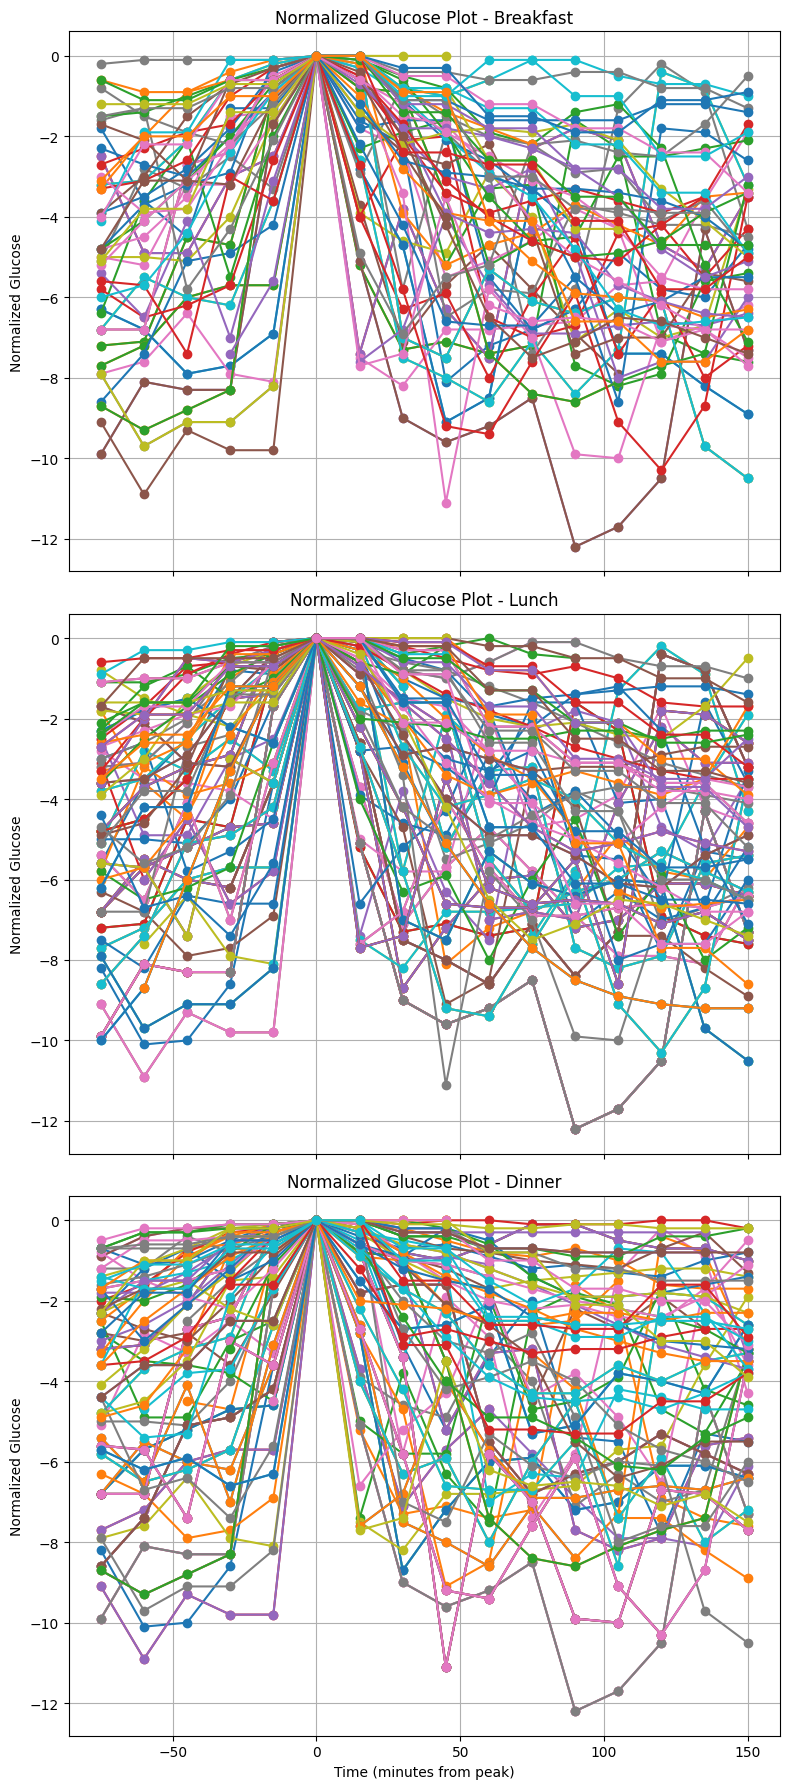

In [23]:
# Define the function to find the peak
def find_peak(arr):
    return max(arr)

# Define the function to adjust values around the peak
def adjust_values(arr):
    peak_index = arr.tolist().index(max(arr))  # Convert to list and then find the index
    start_index = max(0, peak_index - 5)
    end_index = min(len(arr), peak_index + 11)  # 10 values after the peak
    
    if len(arr) < start_index + 1 or len(arr) < end_index:
        return [np.nan] * (end_index - start_index)
    
    adjusted_values = arr[start_index:end_index]
    peak_value = max(adjusted_values)
    normalized_values = [value - peak_value for value in adjusted_values]
    return normalized_values

# Apply the functions to create new columns
GlucoseEvents['PeakGlucose'] = GlucoseEvents['GlucoseLevels'].apply(find_peak)
GlucoseEvents['AdjustedGlucose'] = GlucoseEvents['GlucoseLevels'].apply(adjust_values)

####### CAREFUL WITH THIS ONE, ARRAYS DON'T HAVE THE SAME LENGTH #########################
GlucoseEvents['NormalizedGlucose'] = GlucoseEvents['AdjustedGlucose']

# Generate the array for x-axis values
array = np.arange(-75, 151, 15)

# Group by MealCategory
grouped = GlucoseEvents.groupby('MealCategory')

fig, axs = plt.subplots(len(grouped), 1, figsize=(8, 6*len(grouped)), sharex=True)

# Iterate over each group and plot
for (meal_category, group), ax in zip(grouped, axs):
    for glucose_values in group['NormalizedGlucose']:
        peak_index = np.argmax(glucose_values) - 5  # Find the index of the peak
        x_values = np.arange(-5 * 15, (11 + 1) * 15, 15)[:len(glucose_values)] - peak_index * 15  # Adjust x-values around the peak
        ax.plot(x_values, glucose_values, marker='o')
    ax.set_ylabel('Normalized Glucose')
    ax.set_title(f'Normalized Glucose Plot - {meal_category}')
    ax.grid(True)

# Set common x-axis label
axs[-1].set_xlabel('Time (minutes from peak)')

plt.tight_layout()
plt.show()


######################################## Invidivual Graphs Takes LONG TO COMPILE ###########################

# for i, glucose_values in enumerate(GlucoseEvents['NormalizedGlucose']):
#     # Pad the glucose values with NaN to match the length of the array
#     pad_width = len(array) - len(glucose_values)
#     if pad_width > 0:
#         glucose_values_padded = np.pad(glucose_values, (pad_width, 0), mode='constant', constant_values=np.nan)
#     else:
#         glucose_values_padded = glucose_values

#     plt.figure()  # Create a new figure for each plot
#     plt.plot(array, glucose_values_padded, marker='o')
#     plt.xlabel('Array Values')
#     plt.ylabel('Normalized Glucose')
#     plt.title(f'Normalized Glucose Plot {i+1}')
#     plt.grid(True)
#     plt.show()

In [24]:
GlucoseEvents.head()


,EventTimestamp,GlucoseLevels,EventTag,MealTag,day_of_the_week,hour,MealCategory,PeakGlucose,AdjustedGlucose,NormalizedGlucose
0,2023-10-01 14:11:00,"[8.3, 7.4, 11.8, 10.2, 8.8, 8.7, 5.6, 4.9, 3.0...",50.0,NaN,6,14,Lunch,13.1,"[-8.2, -10.1, -10.0, -8.6, -3.5999999999999996...","[-8.2, -10.1, -10.0, -8.6, -3.5999999999999996..."
1,2023-10-01 21:52:00,"[4.9, 3.0, 3.1, 4.5, 9.5, 13.1, 12.8, 10.0, 7....",35.0,NaN,6,21,Dinner,13.1,"[-8.2, -10.1, -10.0, -8.6, -3.5999999999999996...","[-8.2, -10.1, -10.0, -8.6, -3.5999999999999996..."
2,2023-10-02 07:31:00,"[10.0, 7.9, 9.7, 11.1, 7.7, 7.6, 5.3, 7.8, 7.6...",55.0,NaN,0,7,Breakfast,11.4,"[-1.8000000000000007, -3.6000000000000005, -4....","[-1.8000000000000007, -3.6000000000000005, -4...."
3,2023-10-02 15:42:00,"[7.2, 7.2, 11.2, 6.4, 6.9, 6.5, 6.6, 6.9, 9.6,...",30.0,NaN,0,15,Lunch,11.4,"[-1.8000000000000007, -3.6000000000000005, -4....","[-1.8000000000000007, -3.6000000000000005, -4...."
4,2023-10-03 07:09:00,"[9.2, 3.3, 4.2, 4.6, 5.1, 6.5, 5.6, 5.4, 6.7, ...",11.0,wine-cerealbar1,1,7,Breakfast,12.7,"[-7.199999999999999, -7.1, -4.5, -4.6999999999...","[-7.199999999999999, -7.1, -4.5, -4.6999999999..."


#### Correlate Glucose Events

In [25]:
GlucoseEvents.columns

Index(['EventTimestamp', 'GlucoseLevels', 'EventTag', 'MealTag',
       'day_of_the_week', 'hour', 'MealCategory', 'PeakGlucose',
       'AdjustedGlucose', 'NormalizedGlucose'],
      dtype='object')

In [26]:
# Group by MealCategory
grouped = GlucoseEvents.groupby('MealCategory')

In [27]:
# Now, let's recalculate the correlation matrices
correlation_matrices = {}

# Iterate over each group and calculate correlation matrix
for category, group_df in grouped:
    # Transpose the dataframe to have 'NormalizedGlucose' events as rows
    transposed_df = group_df['NormalizedGlucose'].apply(pd.Series)
    correlation_matrix = transposed_df.corr(method='pearson')
    correlation_matrices[category] = correlation_matrix

# Print or access correlation matrices as needed
for category, correlation_matrix in correlation_matrices.items():
    print(f"Correlation Matrix for MealCategory: {category}")
    print(correlation_matrix)
    print()

Correlation Matrix for MealCategory: Breakfast
          0         1         2         3         4         5         6   \
0   1.000000  0.914382  0.713101  0.610833  0.239473 -0.506732 -0.019576   
1   0.914382  1.000000  0.805168  0.722462  0.415390 -0.370562  0.119086   
2   0.713101  0.805168  1.000000  0.843824  0.525598 -0.267672  0.220256   
3   0.610833  0.722462  0.843824  1.000000  0.696348  0.023391  0.364418   
4   0.239473  0.415390  0.525598  0.696348  1.000000  0.329888  0.354444   
5  -0.506732 -0.370562 -0.267672  0.023391  0.329888  1.000000  0.446071   
6  -0.019576  0.119086  0.220256  0.364418  0.354444  0.446071  1.000000   
7   0.333564  0.404627  0.534667  0.629986  0.517469  0.173734  0.720941   
8   0.393148  0.508332  0.605765  0.610957  0.465061  0.090842  0.514889   
9   0.411608  0.480125  0.598045  0.619874  0.374642  0.137299  0.591185   
10  0.468315  0.469234  0.485693  0.554906  0.244966  0.148910  0.354352   
11  0.655423  0.557235  0.475131  0.52096

In [28]:
from scipy.cluster import hierarchy

def hierarchical_clustering(data, min_group_size=2):
    # Fill missing values with mean
    data_filled = data.fillna(data.mean())
    
    # Calculate pairwise correlation matrix
    correlation_matrix = data_filled.corr()
    
    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - correlation_matrix
    
    # Replace infinite values with a large value
    distance_matrix.replace([np.inf, -np.inf], np.nanmax(distance_matrix.values), inplace=True)
    
    # Set initial lower and upper bounds for threshold
    lower_bound = 0.0
    upper_bound = 1.0
    
    # Perform binary search to find the threshold
    while upper_bound - lower_bound > 1e-5:
        # Calculate midpoint threshold
        threshold = (upper_bound + lower_bound) / 2
        
        # Perform hierarchical clustering
        linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')
        
        # Extract clusters based on the current threshold
        clusters = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
        
        # Count the number of unique clusters
        num_clusters = len(np.unique(clusters))
        
        # Update bounds based on the number of clusters
        if num_clusters <= min_group_size:
            upper_bound = threshold
        else:
            lower_bound = threshold
    
    # Perform hierarchical clustering with the final threshold
    linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')
    clusters = hierarchy.fcluster(linkage_matrix, upper_bound, criterion='distance')
    
    # Group events based on clusters
    grouped_events = {}
    for i, cluster_id in enumerate(clusters):
        if cluster_id not in grouped_events:
            grouped_events[cluster_id] = []
        grouped_events[cluster_id].append(data.index[i])
    
    return grouped_events

# Iterate over each group and perform hierarchical clustering
grouped_clusters = {}
for category, group_df in grouped:
    # Transpose the dataframe to have 'NormalizedGlucose' events as rows
    transposed_df = group_df['NormalizedGlucose'].apply(pd.Series)
    
    # Perform hierarchical clustering
    clusters = hierarchical_clustering(transposed_df, min_group_size=5)
    
    grouped_clusters[category] = clusters

# Print or access grouped events
for category, clusters in grouped_clusters.items():
    print(f"Grouped Events for MealCategory: {category}")
    for cluster_id, events in clusters.items():
        print(f"Cluster {cluster_id}: {events}")
    print()
    

Grouped Events for MealCategory: Breakfast
Cluster 2: [2, 4]
Cluster 3: [7, 10]
Cluster 6: [13]
Cluster 8: [15]
Cluster 7: [19]
Cluster 4: [24, 27, 36]
Cluster 5: [39, 42, 45]
Cluster 1: [49, 54, 60]

Grouped Events for MealCategory: Lunch
Cluster 5: [0, 3, 5, 8]
Cluster 1: [11]
Cluster 3: [16]
Cluster 2: [17]
Cluster 7: [20, 22, 25, 28]
Cluster 6: [30, 31]
Cluster 4: [33, 34, 37]

Grouped Events for MealCategory: Dinner
Cluster 3: [1, 9, 12, 14]
Cluster 2: [18]
Cluster 5: [21]
Cluster 1: [23, 26]
Cluster 4: [29, 32, 35, 38, 41, 44, 48, 52]



/var/folders/9p/vwhkd5c50_j5cz3cyj0q4qsh0000gp/T/ipykernel_93034/2058256337.py:26: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')
/var/folders/9p/vwhkd5c50_j5cz3cyj0q4qsh0000gp/T/ipykernel_93034/2058256337.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


In [29]:
# Split the data into three dataframes based on meal category
breakfast_data = GlucoseEvents[GlucoseEvents['MealCategory'] == 'Breakfast']
lunch_data = GlucoseEvents[GlucoseEvents['MealCategory'] == 'Lunch']
dinner_data = GlucoseEvents[GlucoseEvents['MealCategory'] == 'Dinner']     


Using the Above Clustering process, predict the blood glucose response to a meal based off the meal tag and the previous response as per the cluster formation

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Feature Engineering
features = GlucoseEvents['NormalizedGlucose']
target = GlucoseEvents['MealTag']

# Step 2: Model Training
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train.values.reshape(-1, 1), y_train)  # Reshape to 2D array for single feature

# Step 3: Model Evaluation
y_pred = model.predict(X_test.values.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Step 4: Prediction
# Assuming you have a new MealTag value for prediction
new_meal_tag = 1  # Example value, replace with the actual MealTag

# Predict blood glucose value
predicted_glucose = model.predict([[new_meal_tag]])  # Reshape to 2D array

print("Predicted Blood Glucose Value:", predicted_glucose)

ValueError: setting an array element with a sequence.